In [1]:
using CSV, DataFrames
using Plots
using DataFramesMeta
using Dates

## Problem Intialization
We first set the chosen projection model and relevant date range

In [2]:
model_choice = "ihme"

"ihme"

In [3]:
states_all = CSV.read("processed/state_list.csv")[:State]
if model_choice == "ode"
    df = CSV.read("processed/predicted_ode/AllStates.csv")
elseif model_choice == "ihme"
    df = CSV.read("processed/predicted_ihme/AllStates.csv");
end

states = intersect(unique(df[:State]), states_all)

length(states)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:1
└ @ Core In[3]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:7
└ @ Core In[3]:7


50

##  Capacity Exploration
First, we look at the national forecast for ventilator need and examine the shortfall under fully pooled resources.

In [4]:
function load_projections(state; model="ode", state_list = states)
    if model == "ode"
        df = CSV.read("processed/predicted_ode/AllStates.csv")
    elseif model == "ihme"
        df = CSV.read("processed/predicted_ihme/AllStates.csv")
    end
    if state == "all"
        return df
    else
        df_sub = @where(df, :State .== state)
        df_sub = df_sub[:,2:end] # remove state name
    end
end

load_projections (generic function with 1 method)

In [5]:
t = join(by(dfAll, :State, max_vent = :Ventilators => maximum), df_supply[[:STNAME, :VentCalc_2019]], on = :State => :STNAME)
@where(t, :State .== "New Mexico")

UndefVarError: UndefVarError: dfAll not defined

In [ ]:
dfAll = load_projections("all", model = model_choice)

national_summary = by(dfAll, :Day, Total_Ventilators = :Ventilators => sum)

df_supply = CSV.read("processed/ventilator_table_calculated.csv")
national_supply = sum(@where(df_supply, :STNAME.!="District of Columbia")[:VentCalc_2019])

plot(national_summary[:Day], national_summary[:Total_Ventilators], label = "Total Ventilators")
hline!([national_supply], label = "National Supply")

## What is the cost of the inefficiencies in current state allocation?

In [ ]:
df_join = join(dfAll, df_supply[[:STNAME, :VentCalc_2019]], on = :State => :STNAME, kind = :inner)
df_join[:Shortfall] = max.(df_join[:Ventilators] .- df_join[:VentCalc_2019],0);
shortfall_bystate = by(df_join, :Day, Shortfall = :Shortfall => sum)
plot(shortfall_bystate[:Day], shortfall_bystate[:Shortfall], label  = "State-Level Shortfall")

## Pairwise State Allocation

In [1087]:
## Choose two states 
# s1 = "Delaware"; s2 = "Maryland";
s1 = "Massachusetts"; s2 = "Louisiana"

"Louisiana"

In [1088]:
# Load Data and format predicted ventilator need  - IHME model (temporary)
df1 = load_projections(s1, model = model_choice)
df2 = load_projections(s2, model = model_choice)

df1[Symbol("Vent_$s1")] = df1[:Ventilators]
df2[Symbol("Vent_$s2")] = df2[:Ventilators]

active_cases = join(df1[[:Day, Symbol("Vent_$s1")]], df2[[:Day, Symbol("Vent_$s2")]],
        kind = :inner, on = :Day) |> Matrix;

In [1089]:
days = collect(1:size(active_cases,1))
h1 = active_cases[:,2];
h2 = active_cases[:,3];

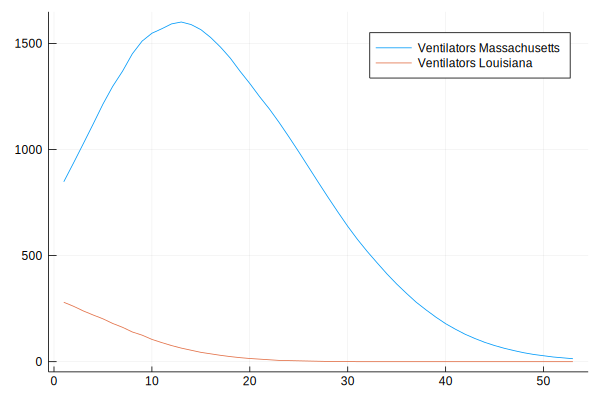

In [1090]:
## Plot anticipated Ventilator demand of each state
plot(days, [h1, h2], label = ["Ventilators $s1" "Ventilators $s2"])

### Load in estimated base stock ventilators in each state 

In [1091]:
df_supply = CSV.read("processed/ventilator_table_calculated.csv")
supply1 = df_supply[df_supply[:STNAME].==s1,:VentCalc_2019][1]
supply2 = df_supply[df_supply[:STNAME].==s2,:VentCalc_2019][1]
println("$s1 Supply: ", supply1)
println("$s2 Supply: ", supply2)

Massachusetts Supply: 1482
Louisiana Supply: 1137


In [1092]:
supply1+supply2

2619

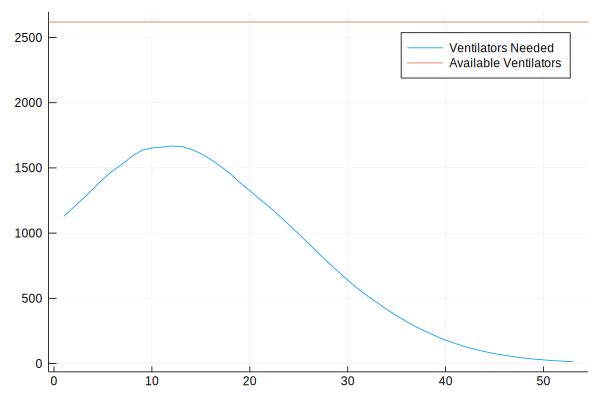

In [1093]:
## Demand Shortage
plot(days, [h1.+h2], label = "Ventilators Needed")
plot!([supply1+supply2], seriestype = :hline, label = "Available Ventilators")

In [1094]:
include("src/mip.jl")

Academic license - for non-commercial use only


allocate_ventilators

In [1095]:
demands = vcat(h1', h2')
distances = ones(2, 2)
base_supply = [supply1, supply2]
surge_supply = zeros(length(days))
delays = 2 * ones(Int, (2, 2))
supply, transfers = allocate_ventilators(demands, base_supply, surge_supply,
                                         distances, delays, TimeLimit=10, OutputFlag=0);

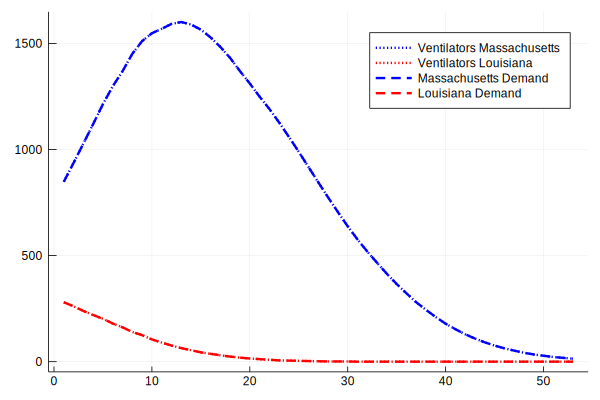

In [1096]:
x1 = supply[1, :]
x2 = supply[2, :]
plot(days, [min.(x1, h1) min.(x2, h2)], lw=3, ls=:dot, lc=[:blue :red], label=["Ventilators $s1" "Ventilators $s2"])
plot!(days, [h1 h2], lw=3, ls=:dash, lc=[:blue :red], label=["$s1 Demand" "$s2 Demand"])

# 50-state allocation problem

1) Load the demand data from IHME

In [1097]:
df = load_projections(s1, model = model_choice);

In [1098]:
print(states)
state = states[1]
df = load_projections(state, model = model_choice)
df[:, Symbol("Vent_$state")] = df[:, :Ventilators]
df = df[:, [:Day, Symbol("Vent_$state")]]
for state in states[2:end]
    tmpdf = load_projections(state, model = model_choice)
    print(size(tmpdf))
    tmpdf[:, Symbol("Vent_$state")] = tmpdf[:, :Ventilators]
    tmpdf = tmpdf[:, [:Day, Symbol("Vent_$state")]]
    df = join(df, tmpdf, kind=:inner, on = :Day)
end
demand_days = df[:,1]
demands = df[:,2:end] |> Matrix
demands = Matrix(demands');

# state = states[1]
# df = CSV.read("processed/predicted_ihme/$(state).csv")
# df[!, Symbol("Vent_$state")] = df[!, :Ventilators]
# df = df[!, [:Day, Symbol("Vent_$state")]]
# for state in states[2:end]
#     tmpdf = CSV.read("processed/predicted_ihme/$(state).csv")
#     tmpdf[!, Symbol("Vent_$state")] = tmpdf[!, :Ventilators]
#     tmpdf = tmpdf[!, [:Day, Symbol("Vent_$state")]]
#     df = join(df, tmpdf, kind=:inner, on = :Day)
# end
# demands = select(df, Not(:Day)) |> Matrix
# demands = Matrix(demands');

["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"](53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)(53, 4)

2) Load base supply

In [1099]:
df_supply = CSV.read("processed/ventilator_table_calculated.csv")
base_supply = zeros(length(states))
for (i, state) in enumerate(states)
    base_supply[i] = df_supply[df_supply[:, :STNAME].==state,:VentCalc_2019][1].*.75
end

# df_supply = CSV.read("processed/ventilator_table_calculated.csv")
# base_supply = zeros(length(states))
# for (i, state) in enumerate(states)
#     base_supply[i] = df_supply[df_supply[!, :STNAME].==state,:VentCalc_2019][1]
# end

3) Surge supply (for now, nothing) - in fact, not even implemented in MIP

In [1101]:
surge_supply = zeros(size(demands, 2));

surge_supply = 450.0 * ones(size(demands, 2))
surge_supply[1:3] .= 0.0
surge_supply[33:end] .= 0.0
surge_supply

53-element Array{Float64,1}:
   0.0
   0.0
   0.0
 450.0
 450.0
 450.0
 450.0
 450.0
 450.0
 450.0
 450.0
 450.0
 450.0
   ⋮  
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0

4) Distance matrix

In [1102]:
distances_full = CSV.read("processed/state_distances.csv")
distances = @where(distances_full, [x in states for x in :Column1])[Symbol.(states)]
distances = distances |> Matrix;
# distances = select(distances, Not(:Column1)) |> Matrix;

In [1103]:
distances

50×50 Array{Float64,2}:
  0.0      43.7919   24.9274    5.94796  …   8.42688  12.434    23.0191 
 43.7919    0.0      21.681    37.8455      47.8258   37.5457   20.9331 
 24.9274   21.681     0.0      19.3326      31.2423   23.9901    9.85283
  5.94796  37.8455   19.3326    0.0         12.203    10.126    17.1136 
 33.2568   14.7513    8.47046  27.5327      39.152    30.8503   14.1116 
 19.725    24.1717    7.56537  13.7899   …  24.8478   16.6083    4.70729
 16.9772   55.4242   39.954    21.0886       8.89421  17.8903   34.9291 
 13.2483   53.3245   36.9112   17.7586       5.68822  16.1338   32.5668 
  6.92107  50.3298   30.6049   12.6376      10.5951   18.6702   29.7353 
  3.38708  47.0247   28.3143    9.24282      6.66229  13.9341   26.177  
 39.508    17.5285   14.832    34.0816   …  46.069    38.4636   22.1014 
 29.3112   14.4825    9.62566  23.3641      33.659    23.958     6.69379
  7.90836  38.9739   22.9987    6.06585      8.86212   4.58583  18.1285 
  ⋮                        

In [1104]:
delays = 3 * ones(Int, size(distances));

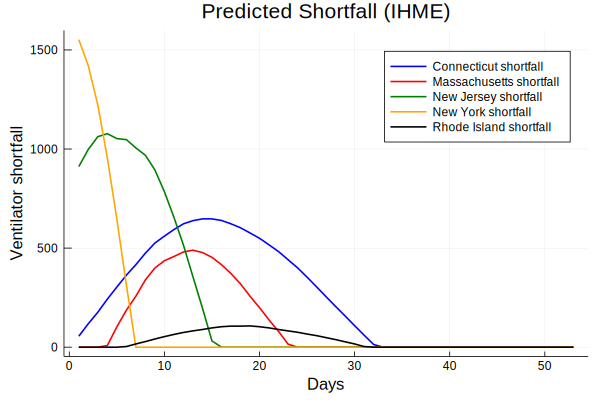

In [1105]:
plot()
state_ids = []
for i = eachindex(states)
    if any(demands[i, :] .- base_supply[i] .> 0)
        push!(state_ids, i)
    end
end
colors = [:blue, :red, :green, :orange, :black, :gray, :blue, :red, :green, :orange, :black, :gray,
          :blue, :red, :green, :orange, :black, :gray, :blue, :red, :green, :orange, :black, :gray,
          :blue, :red, :green, :orange, :black, :gray, :blue, :red, :green, :orange, :black, :gray,
          :blue, :red, :green, :orange, :black, :gray]
for (idx, i) in enumerate(state_ids)
    plot!(eachindex(demands[i, :]), max.(demands[i, :] .- base_supply[i], 0),
        lc=colors[idx], lw=2, label="$(states[i]) shortfall")
end
ylabel!("Ventilator shortfall")
xlabel!("Days")
title!("Predicted Shortfall ($(uppercase(model_choice)))")

In [1106]:
include("src/mip.jl")

Academic license - for non-commercial use only


allocate_ventilators

In [1107]:
@time supply, transfers, surge = allocate_ventilators(demands, base_supply .* 0.5, surge_supply, distances,
    delays, lasso=1e-1, only_send_excess=true, minimum_stock_fraction = 0.8, easy_incentive = false,
    max_ship_per_day = 3000.0, vent_days = 10,
    OutputFlag=1, TimeLimit=120);

Optimize a model with 21253 rows, 145800 columns and 1773082 nonzeros
Variable types: 8000 continuous, 137800 integer (2650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [2e-01, 7e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 5e+03]
Presolve removed 13817 rows and 34997 columns (presolve time = 5s) ...
Presolve removed 14075 rows and 39997 columns
Presolve time: 6.13s
Presolved: 7178 rows, 105803 columns, 1272987 nonzeros
Variable types: 486 continuous, 105317 integer (278 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7747113e+04   2.409767e+04   0.000000e+00      7s
    2136    3.3714289e+04   0.000000e+00   0.000000e+00      7s

Root relaxation: objective 3.371429e+04, 2136 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3371

In [1111]:
surge

50×53 Array{Float64,2}:
 0.0  0.0  0.0    0.0  -0.0  -0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   -0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  243.0  61.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   -0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0    0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0   -0.0  -0.0  -0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                            ⋮    ⋱    

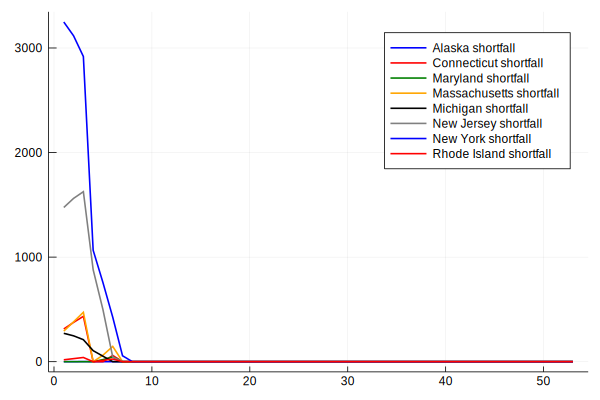

In [1112]:
idx = 0
plot()
for i = eachindex(states)
    if any(demands[i, :] .- supply[i, :] .> 0)
        idx += 1
        plot!(eachindex(demands[i, :]), max.(demands[i, :] .- supply[i, :], 0),
                        lc=colors[idx], lw=2, label="$(states[i]) shortfall")
    end
end
plot!()

In [1113]:
include("src/output_helpers.jl")

supplies_to_long (generic function with 3 methods)

In [1114]:
#print_flows(transfers)

In [1115]:
transfers_to_long(transfers, states, demand_days, surge = surge)[50:end,:]

,State_From,State_To,Day,Num_Units
,String,String,Any,Real
1,Federal,North Dakota,2020-04-15,14.0
2,Federal,Alaska,2020-04-15,2.0
3,Federal,Connecticut,2020-04-16,157.0
4,Federal,Massachusetts,2020-04-16,155.0
5,Federal,Georgia,2020-04-16,50.0
6,Federal,Maryland,2020-04-16,50.0
7,Federal,Rhode Island,2020-04-16,30.0
8,Federal,Alaska,2020-04-16,8.0
9,Federal,Connecticut,2020-04-17,163.0


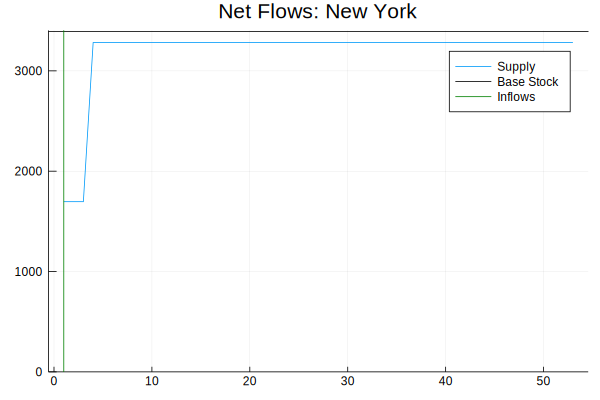

In [1116]:
plot_netflow(supply, transfers, "New York")

In [1117]:
# include("src/plot_flows.jl") # assumes 3 day delay
# plot_netflow(supply, transfers, "New York")

## Save results in long format for website

In [1118]:
# Create dummy table (Supply 1 = 0.8 min_stock, Supply 2 = 0.5 min_stock)
# supply1 = supplies_to_long(supply, demands, states, demand_days, base_supply)
# supply2 = join(supply1, supplies_to_long(supply, demands, states, demand_days, base_supply), 
#     on = [:State, :Date, :Base_Supply], makeunique = true)
# CSV.write("results/state_supplies_table_test.csv", supply2)

In [1119]:
# t = transfers_to_long(transfers, states, demand_days)
# CSV.write("results/transfers_table_test.csv", t)

## Parameter Analysis 
In this section we assess the impact of different parameters on the realized shortfall and number of transfers. We specifically explore:
- Utilization: what % of ventilators are utilized for non-COVID patients? A higher utilization proportion means that **fewer ventilators** are available.
- Only_send_excess: Can transfers be initiated at any point, or does a state need to have excess ventilators available before a transfer is allowed?
- Minimum_stock_fraction: What proportion of stock is required to remain in the origin state? A higher proportion gives the model **less flexibility** in re-allocating ventilators.

In [1120]:
surge_supply = zeros(size(demands, 2));
surge_supply[1:30] .= 450;

In [1121]:
surge_supply = zeros(size(demands, 2));
surge_supply[[3,10,17]] .= 450;

In [916]:
surge

UndefVarError: UndefVarError: surge not defined

In [905]:
param_results = DataFrame(lasso = Float64[], transfer_count = Real[], shortfall = Float64[])

# for l in [0.05,0.1,0.2]
# println("Parameter l = $l")
surge_supply = zeros(size(demands, 2));
surge_supply[[3,10,17]] .= 1000;

supply, transfers = allocate_ventilators(demands, base_supply .* 0.5, surge_supply, distances,
    delays, lasso=0.1, only_send_excess=true, minimum_stock_fraction = 0.8, 
    easy_incentive = false, vent_days = 0,
    max_ship_per_day = 3000.0, OutputFlag=1, TimeLimit=120);
shortfall = sum(max.([0], demands .- supply))
transfer_count = sum(transfers .> 1e-5)
println([l, transfer_count, shortfall])

# push!(param_results, [l, transfer_count, shortfall])
# end

Optimize a model with 42170 rows, 330050 columns and 1273021 nonzeros
Variable types: 24050 continuous, 306000 integer (6000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [2e-01, 7e+00]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 6e+03]
Presolve removed 34826 rows and 184251 columns
Presolve time: 2.39s
Presolved: 7344 rows, 145799 columns, 428153 nonzeros
Variable types: 4037 continuous, 141762 integer (514 binary)

Root relaxation: objective 1.117338e+05, 5484 iterations, 0.71 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 111733.832    0   79          - 111733.832      -     -    3s
     0     0 111746.235    0   67          - 111746.235      -     -    5s
     0     0 111754.095    0   68          - 111754.095      -     -    7s
     0     0 111754.113    0   70          - 111754.113      -     -    9s


In [906]:
print_flows(transfers)

Day 1:
	 Minnesota	 => Utah		: 10.0
	 Idaho		 => Rhode Island	: 14.0
	 Kentucky	 => North Dakota	: 56.0
	 West Virginia	 => New Mexico		: 5.0
	 Wyoming	 => New Jersey		: 9.0
	 Texas		 => New Jersey		: 468.0
	 Tennessee	 => New Jersey		: 122.0
	 South Dakota	 => New Jersey		: 12.0
	 North Carolina	 => New Jersey		: 147.0
	 Nebraska	 => New Jersey		: 37.0
	 Louisiana	 => New Jersey		: 85.0
	 Kansas		 => New Jersey		: 1.0
	 Iowa		 => New Jersey		: 32.0
	 Hawaii		 => New Jersey		: 18.0
	 Florida	 => New Jersey		: 348.0
	 California	 => New Jersey		: 524.0
	 Minnesota	 => Nevada		: 54.0
	 Oklahoma	 => Massachusetts	: 3.0
	 New Hampshire	 => Massachusetts	: 16.0
	 Nevada		 => Massachusetts	: 64.0
	 Missouri	 => Massachusetts	: 105.0
	 Mississippi	 => Massachusetts	: 8.0
	 Maine		 => Massachusetts	: 16.0
	 Idaho		 => Massachusetts	: 1.0
	 Colorado	 => Massachusetts	: 78.0
	 Alabama	 => Massachusetts	: 14.0
	 Washington	 => Maryland		: 71.0
	 New Mexico	 => Maryland		: 27.0
	 Florida	 => Maryl

In [907]:
param_results

,lasso,transfer_count,shortfall
,Float64,Real,Float64


In [899]:
# param_results = DataFrame(utilization = Float64[], only_send_excess = Bool[], 
#     minimum_stock_fraction = Float64[], transfer_count = Real[], shortfall = Float64[])
# for util in .1:.2:.5, excess in [true, false], min_stock in .7:.1:1.0
#     supply, transfers = allocate_ventilators(demands, base_supply .* (1-util), surge_supply, distances,
#         delays, lasso=1e-1, only_send_excess=excess, min_transfer_size=0, minimum_stock_fraction = min_stock,
#         max_ship_per_day = 3000.0, OutputFlag=0, TimeLimit=120);
#     shortfall = sum(max.([0], demands .- supply))
#     transfer_count = sum(transfers .> 1e-5)
#     println([util, excess, min_stock, transfer_count, shortfall])
#     push!(param_results, [util, excess, min_stock, transfer_count, shortfall])
# end
# CSV.write("results/parameter_sensitivity_$(model_choice)_v2.csv", param_results)

In [900]:
#check that unconstrained solution has 0 shortfall (sanity check) 

# supply, transfers = allocate_ventilators(demands, base_supply .* (1.5), surge_supply, distances,
#         3*zeros(Int, size(distances)), lasso=0, only_send_excess=false, min_transfer_size=0, minimum_stock_fraction = 0.0,
#         max_ship_per_day = 10000.0, OutputFlag=1, TimeLimit=120);

In [901]:
param_results = CSV.read("results/parameter_sensitivity_$(model_choice).csv");

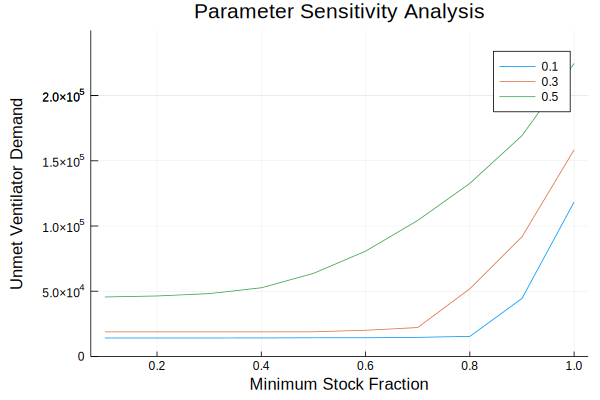

In [902]:
df_plot = @where(param_results, :only_send_excess .== true, (:utilization .== .1) .| (:utilization .== .3) .| (:utilization .== .5))

plot(df_plot[:minimum_stock_fraction], df_plot[:shortfall], group = df_plot[:utilization],
    xlab = "Minimum Stock Fraction", ylab = "Unmet Ventilator Demand",
    title = "Parameter Sensitivity Analysis",
    ylims = (0, 2.5e5))

In [903]:
include("src/output_helpers.jl")

supplies_to_long (generic function with 3 methods)

In [582]:
t = supplies_to_long(supply, demands, states, demand_days, base_supply)
@where(t, :State .== "US")

,State,Date,Supply_Excess,Supply,Demand
,Any,Symbol,Float64,Any,Any
1,US,2020-04-01,-7124.5,29819.0,19080
2,US,2020-04-02,-8193.5,29564.0,21037
3,US,2020-04-03,-9195.0,28884.0,22950
4,US,2020-04-04,-7259.0,31622.0,24768
5,US,2020-04-05,-7645.5,31543.0,26461
6,US,2020-04-06,-7859.0,32223.0,27979
7,US,2020-04-07,-7921.0,32565.0,29295
8,US,2020-04-08,-7917.5,32899.0,30390
9,US,2020-04-09,-8013.5,32896.0,31249


In [587]:
supply_table = DataFrame()
transfers_table = DataFrame()

for util in .1:.2:.5, excess in [true], min_stock in [.5, .8]
    supply, transfers = allocate_ventilators(demands, base_supply .* (1-util), surge_supply, distances,
        delays, lasso=1e-1, only_send_excess=excess, min_transfer_size=0, minimum_stock_fraction = min_stock,
        max_ship_per_day = 3000.0, OutputFlag=0, TimeLimit=120);
    
    ## Supply table
    supply_long = supplies_to_long(round.(supply), demands, states, demand_days, base_supply)
    supply_long[:Param1] = util
    supply_long[:Param2] = min_stock
    supply_long[:Param3] = excess
    supply_table = vcat(supply_table, supply_long)
    
    ## Transfer table
    transfers_long = transfers_to_long(transfers, states, demand_days)
    transfers_long[:Param1] = util
    transfers_long[:Param2] = min_stock
    transfers_long[:Param3] = excess
    transfers_table = vcat(transfers_table, transfers_long)
end

In [591]:
CSV.write("results/state_supplies_table_test_v2.csv", supply_table)
CSV.write("results/transfers_table_test_v2.csv", transfers_table)

"results/transfers_table_test_v2.csv"